## Zadanie 1
Napisz implementacje funkcji loss bazując na poprzednim notebooku, a następnie porównaj loss dla zdjęcia org z zdjęciami b1 ... b5.
Zrób wykresy ilustrujące loss względem każdego z zdjęć

Text(0, 0.5, 'Losses')

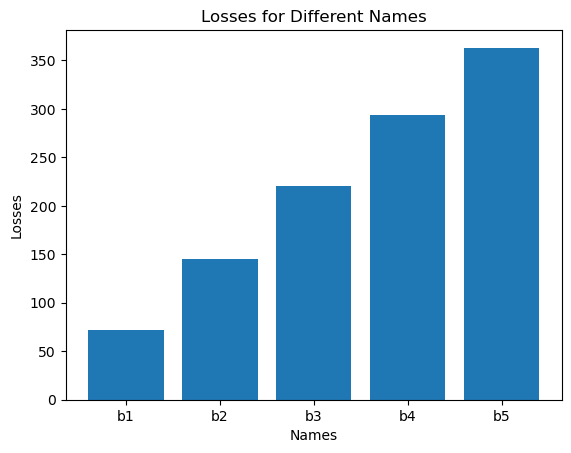

In [1]:
import torch
import matplotlib.pyplot as pyplot
from PIL import Image
from torchvision import transforms

# Load original image
org = Image.open('elza/org.jpg') 
transform = transforms.Compose([transforms.PILToTensor()]) 
org_tensor = transform(org)
losses = []
names = []
for i in range(1,6):
    name = 'b'+ str(i)
    src = 'elza/'+ name +'.jpg'
    copy = Image.open(src) 
    copy_tensor = transform(copy)
    
    # Make sure the two images have the same dimensions
    assert copy_tensor.shape == org_tensor.shape, "Images must have the same dimensions!"
    
    # Compute MSE
    mse_loss = torch.nn.functional.mse_loss(org_tensor.float(), copy_tensor.float())
    losses.append(mse_loss)
    names.append(name)
    
fig, ax = pyplot.subplots()
ax.bar(names, losses)
ax.set_title('Losses for Different Names')
ax.set_xlabel('Names')
ax.set_ylabel('Losses')


## Zadanie 2
Napisz i wytrenuj prosty model którego zadaniem bedzie klasyfikacja czy punkt znajduje sie wewnątrz koła jednostkowego czy może poza nim.
Następnie spróbuj użyć Fourier Feature do zmapowania wejścia. 
Poeksperymentuj z różnymi rodzajami transformacji ( parametr L oraz mnożenie przez macierz B)
Wyniki zilustruj wykresami

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

L = 10  
N = 1000 
E = 500

train = np.random.uniform(-2., 2., (N, 2))
label_train = np.zeros(N)

for i in range(N):
    if np.linalg.norm(train[i]) < 1.0:
        label_train[i] = 1

data_train = torch.tensor(train, dtype=torch.float32)
data_label_train= torch.tensor(label_train, dtype=torch.float32)

test_size = N//6

test = np.random.uniform(-2., 2., (test_size, 2))
label_test = np.zeros(test_size)

for i in range(test_size):
    if np.linalg.norm(test[i]) < 1.0:
        label_test[i] = 1

data_test = torch.tensor(test, dtype=torch.float32)
data_label_test= torch.tensor(label_test, dtype=torch.float32)

In [3]:
class FourierNet(nn.Module):
    def __init__(self, L):
        super(FourierNet, self).__init__()
        self.L = L
        self.B = torch.randn(2*L)  # Change this line
        self.fc1 = nn.Linear(4*L, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        stacked = []
        for i in range(self.L):
            stacked.append(torch.sin(2. * np.pi * x * self.B[2*i]))  # Use element-wise multiplication here
            stacked.append(torch.cos(2. * np.pi * x * self.B[2*i + 1]))  # Use element-wise multiplication here
        x = torch.cat(stacked, dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class RegularNet(nn.Module):
    def __init__(self):
        super(RegularNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

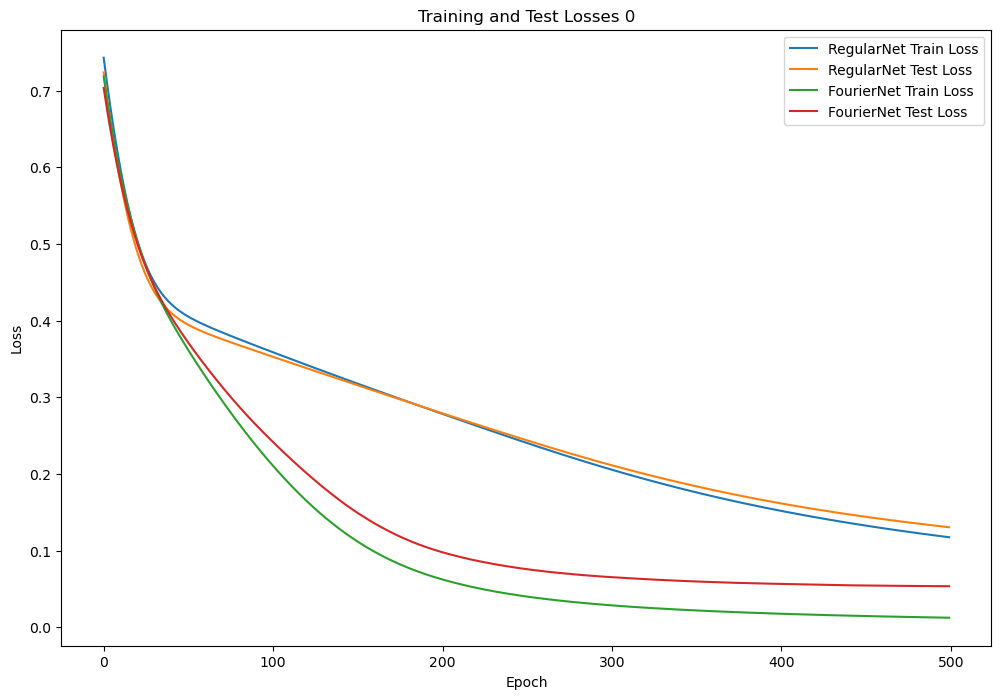

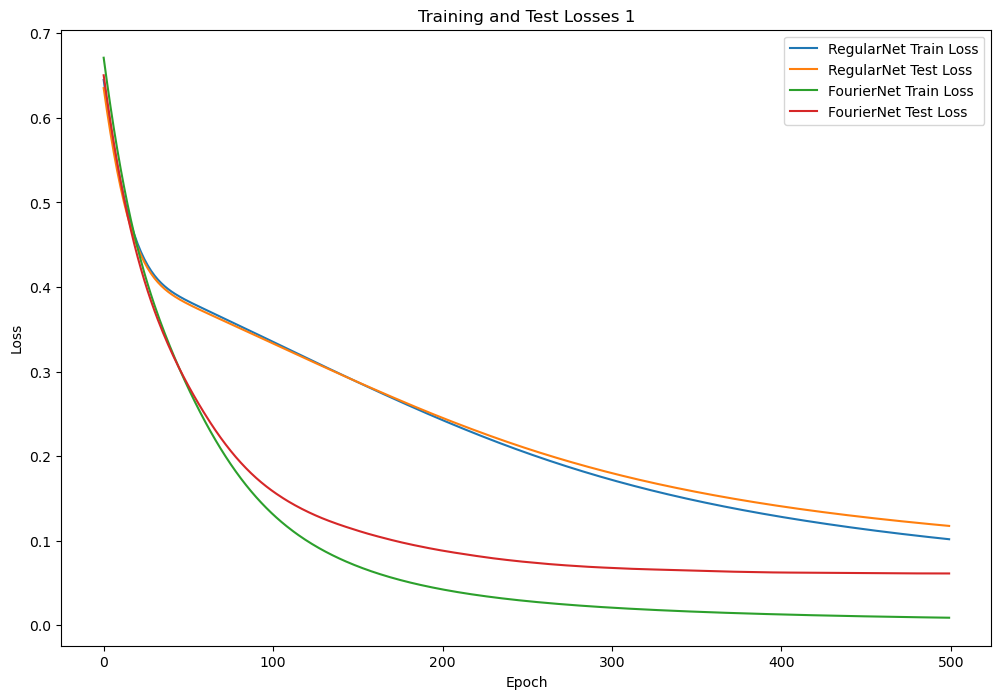

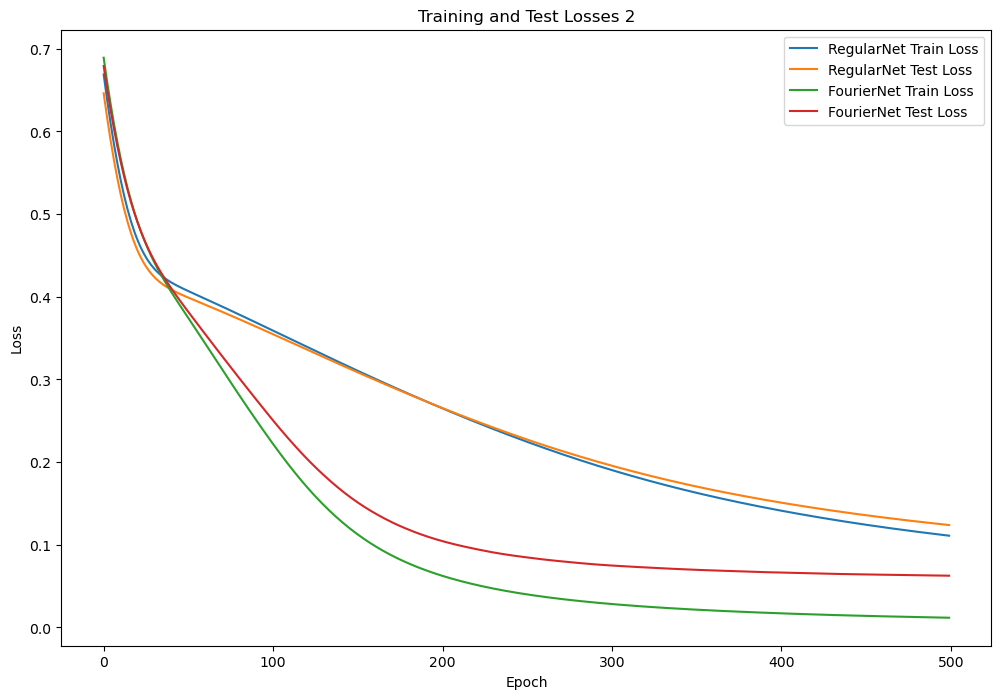

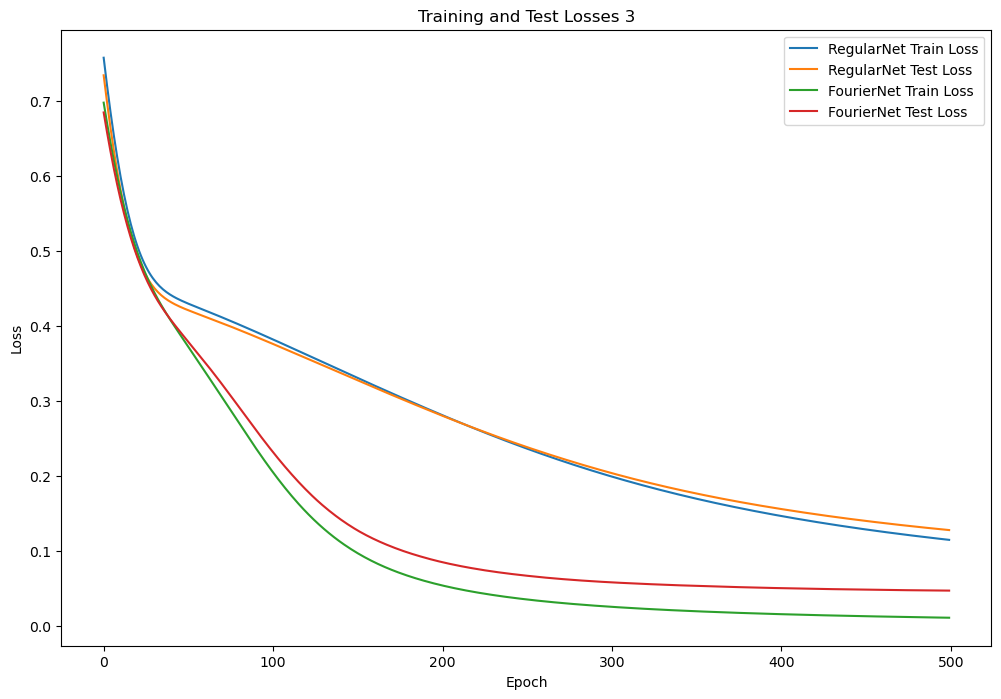

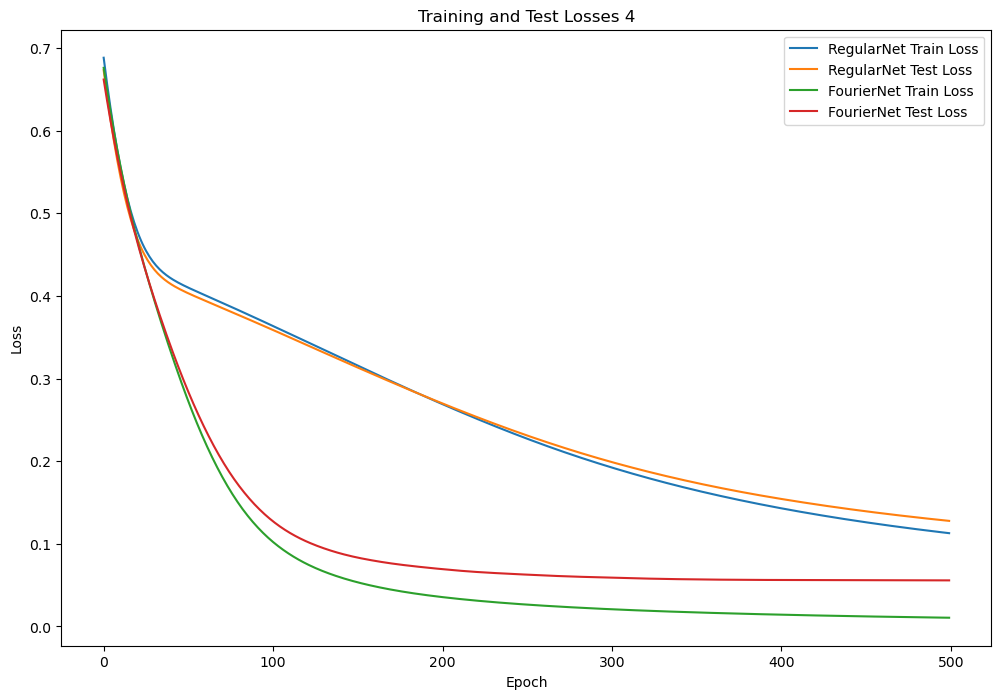

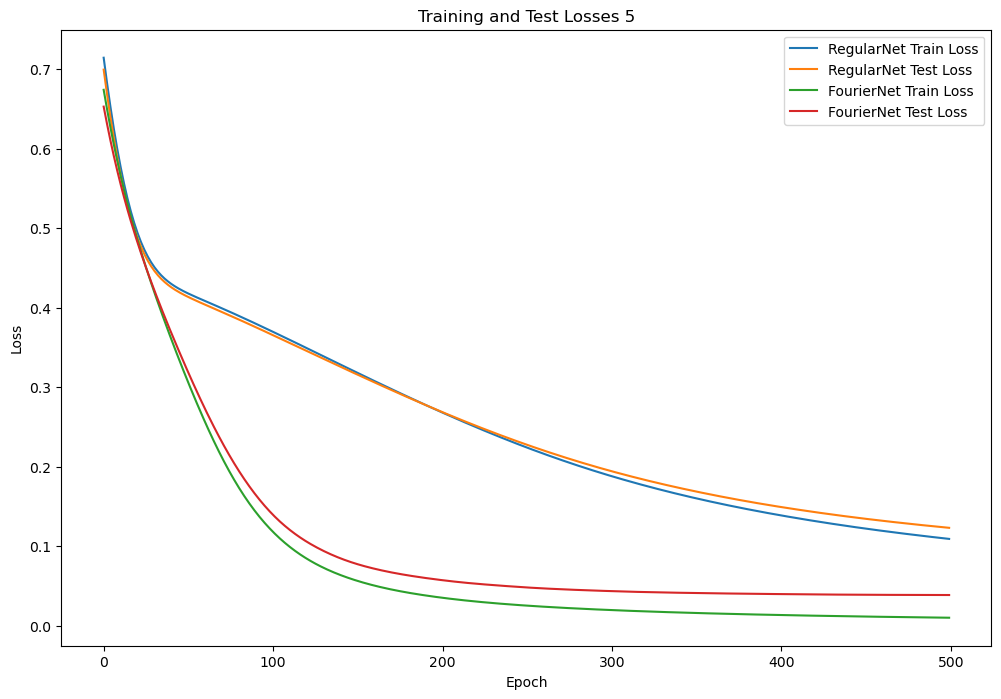

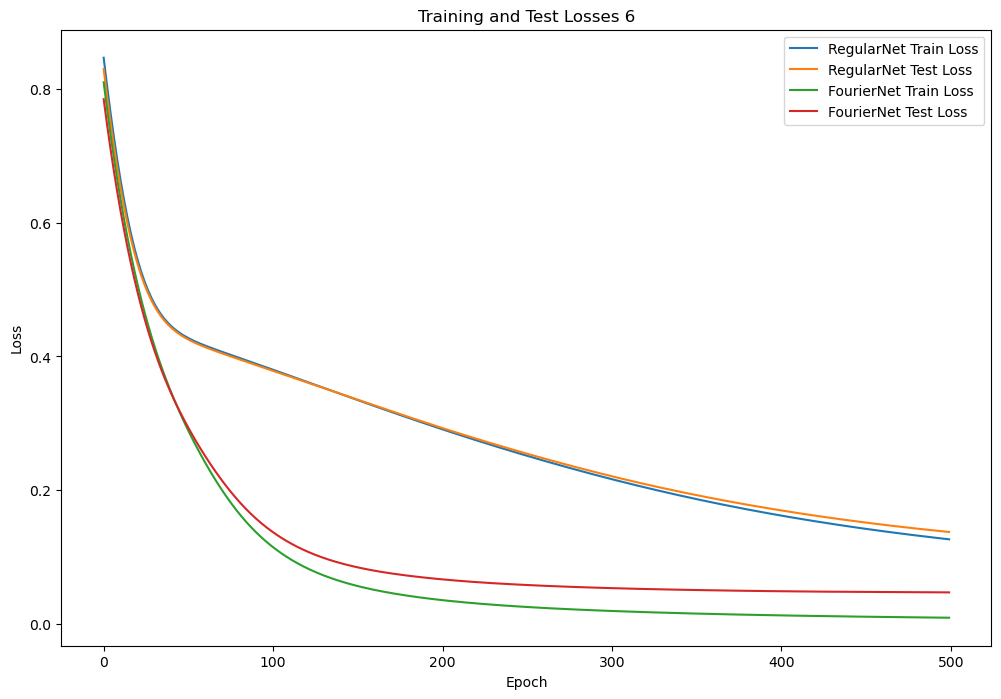

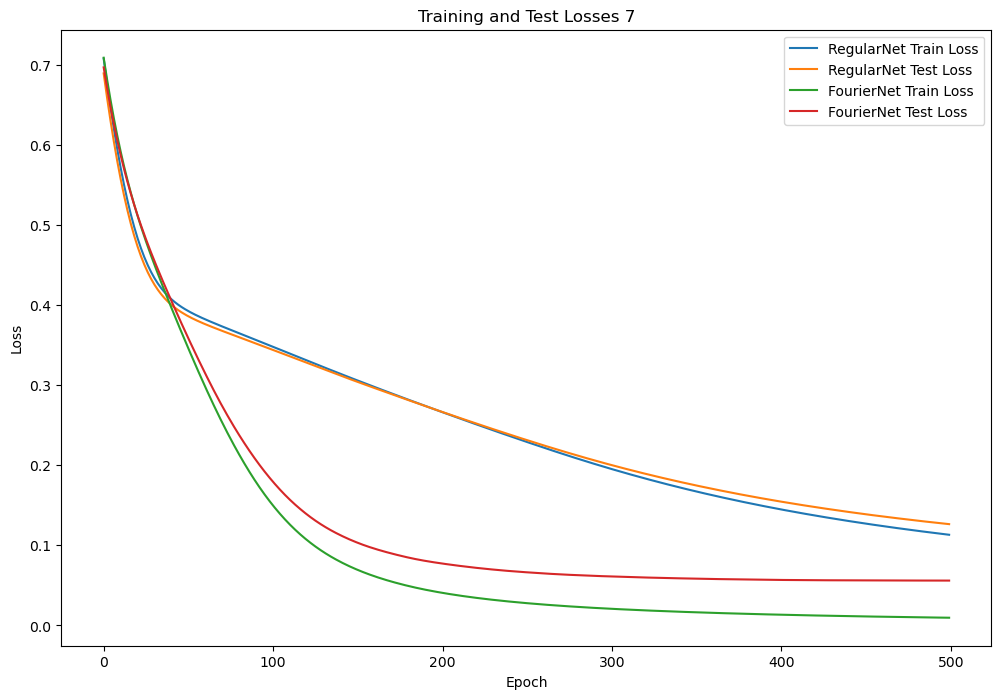

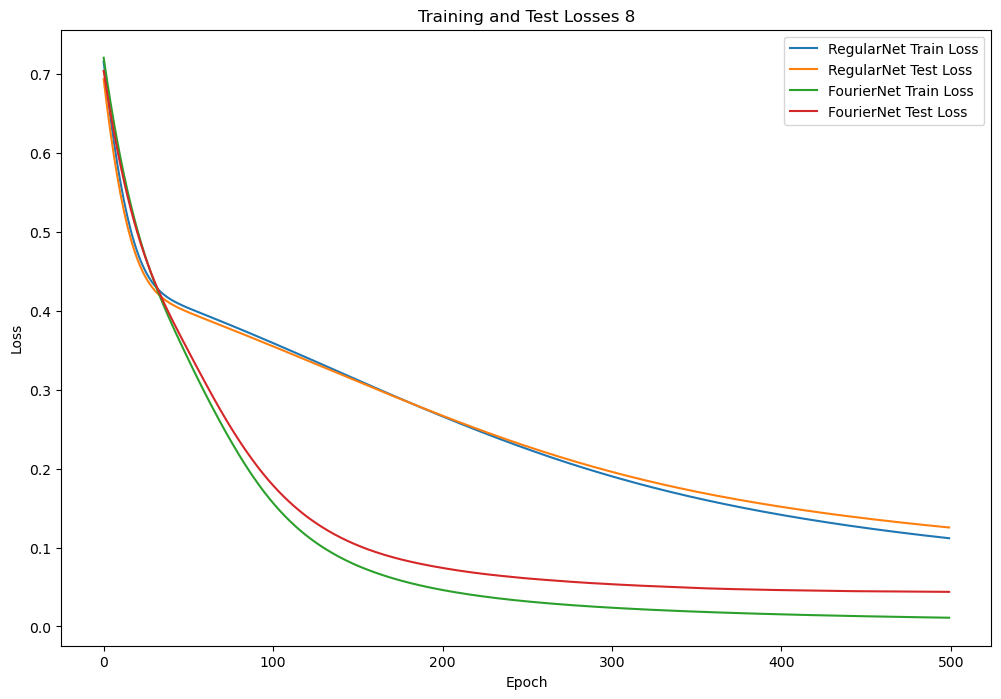

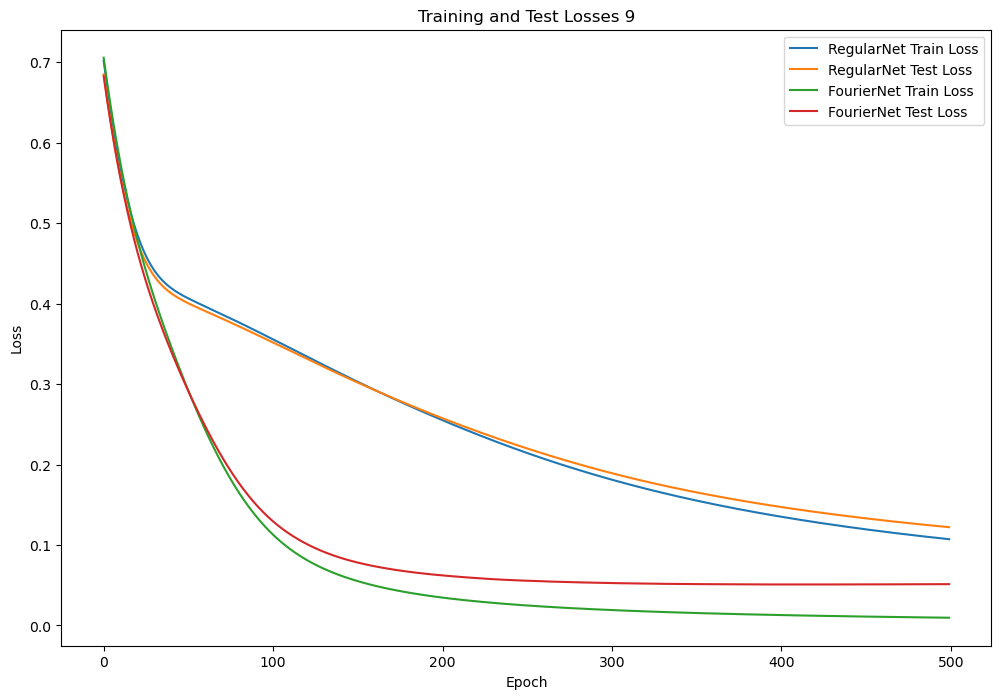

In [4]:
for i in range(10):
    reg = RegularNet()
    criterion_reg = torch.nn.BCELoss() 
    optimizer_reg = optim.Adam(reg.parameters(), lr=0.001)
    train_loss_reg = []
    test_loss_reg = []
    
    for epoch in range(E):
        outputs = reg(data_train)
        loss = criterion_reg(outputs.squeeze(), data_label_train)
        train_loss_reg.append(loss.item())
        loss.backward()
        optimizer_reg.step()
    
        optimizer_reg.zero_grad()
        
        with torch.no_grad():
            outputs_test = reg(data_test)
            loss_test = criterion_reg(outputs_test.squeeze(), data_label_test).item()
            test_loss_reg.append(loss_test)
        
    
    fourier = FourierNet(L)
    criterion_fourier = torch.nn.BCELoss() 
    optimizer_fourier = optim.Adam(fourier.parameters(), lr=0.001)
    train_loss_fourier = []
    test_loss_fourier = []
    
    for epoch in range(E):
        outputs = fourier(data_train)
        loss = criterion_fourier(outputs.squeeze(), data_label_train)
        train_loss_fourier.append(loss.item())
    
        loss.backward()
        optimizer_fourier.step()  
    
        optimizer_fourier.zero_grad()  
        
        with torch.no_grad():
            outputs_test = fourier(data_test)
            loss_test = criterion_fourier(outputs_test.squeeze(), data_label_test).item()
            test_loss_fourier.append(loss_test)
        
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(train_loss_reg, label='RegularNet Train Loss')
    plt.plot(test_loss_reg, label='RegularNet Test Loss')
    
    plt.plot(train_loss_fourier, label='FourierNet Train Loss')
    plt.plot(test_loss_fourier, label='FourierNet Test Loss')
    
    plt.title('Training and Test Losses '+ str(i))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

## Zadanie 3
Napisz i wytrenuj 2 modele których zadaniem bedzie zapamiętanie zdjęcia. Jeden z nich niech wykorzystuje Fourier Feature a drugi nie.
Zdjęciem które bedzie należy zapamietać jest org.jpg ( dla ułatwienia można je przeskalować do rozmiarów 512 x 512 ).
Dla modelu bez FF proponuje następującą strukture:
Conv2d( 2,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,3,kernel_size=1,padding=0)
Sigmoid()

dla modelu z FF proponuje taki model: (trzeba z 2 wejść zrobić 256)
Conv2d( 256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,256,kernel_size=1,padding=0)
ReLU()
BatchNorm2d(256)
Conv2d(256,3,kernel_size=1,padding=0)
Sigmoid()